ETL Process

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,classification_report,precision_score,f1_score,recall_score,confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.utils import resample
import warnings
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
warnings.filterwarnings("ignore")

In [2]:
# 定义特征选择函数
def select_best_features(x1,y,num,fea_names):
    x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, shuffle=False)
    skb1 = SelectKBest(chi2, k=num)
    x_train_new1 = skb1.fit_transform(x_train, y_train)
    x_test_new1 = skb1.transform(x_test)
    selected_features = skb1.get_support(indices=True)
    x_train_new1=pd.DataFrame(x_train_new1, columns=fea_names[selected_features])
    x_test_new1=pd.DataFrame(x_test_new1, columns=fea_names[selected_features])
    return  pd.concat([x_train_new1,x_test_new1], ignore_index=True),fea_names[selected_features]

# 模型交叉验证函数，输出平均准确率和方差
def evaluate_model_with_cv(model, X, y, cv=2):
    accuracies = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    return mean_acc, std_acc

# 指标roc-auc曲线绘制函数
def data_convert(y):
    K = len(np.unique(y.tolist()))
    eyes_mat = np.eye(K)
    y_onehot = np.zeros((y.shape[0], K))
    for i in range(0, y.shape[0]):
        y_onehot[i] = eyes_mat[y[i]]
    return y_onehot
def roc_auc_curve(y_onehot, y_score):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes=2
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

      plt.figure()
      lw = 2
      plt.plot(fpr[i], tpr[i], color='darkorange',
                lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('class '+str(i))
      plt.legend(loc="lower right")
      plt.show()
# 定义随机采样函数
def resample_data(data, n):
    df1 = pd.DataFrame()
    
    labels = data['Label'].unique()  # 直接使用列名 'Label'
    seed = 42

    for label in labels:
        # 选择特定标签的数据
        df2 = data[data['Label'] == label]  # 这里直接使用 data['Label'] 而非 iloc
        
        len1 = len(df2)
        
        if len1 >= n:
            df1_ = df2.sample(n=n, replace=False, random_state=seed)  # 随机抽样
        else:
            df1_ = df2.sample(n=n, replace=True, random_state=seed)  # 数据不够时进行放回抽样

        df1 = pd.concat([df1, df1_])
    
    return df1

# 首先，找到最佳的标签匹配
def get_cluster_accuracy(y_true, cluster_labels):
    # 获取唯一标签
    unique_true_labels = np.unique(y_true)
    unique_cluster_labels = np.unique(cluster_labels)
    
    # 构建 cost matrix
    cost_matrix = np.zeros((len(unique_true_labels), len(unique_cluster_labels)))
    
    for i, true_label in enumerate(unique_true_labels):
        for j, cluster_label in enumerate(unique_cluster_labels):
            cost_matrix[i, j] = np.sum((y_true == true_label) & (cluster_labels == cluster_label))
    
    # 通过匈牙利算法找到最佳匹配
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)  # 最大化 cost_matrix
    
    # 计算准确率
    accuracy = cost_matrix[row_ind, col_ind].sum() / len(y_true)
    return accuracy

In [3]:
#读取数据
data_02=pd.read_csv('03-02-2018.csv')
data_03=pd.read_csv('02-15-2018.csv')
#合并
data=pd.concat([data_02,data_03],axis=0)
print(data.shape)

(2097150, 80)


In [5]:
# 去除多余的行
data1=data.copy()
mask = data1['Label'] != 'Label'
data1 =data1.drop(data[~mask].index)
data1 = data1.sample(n=500000, random_state=42)

In [6]:
#去除Timestap这一列
data2=data1.copy()
data2=data2.drop('Timestamp',axis=1)

In [7]:
# 保留 Label 列
label_column = data2['Label']

# 将除了 Label 列之外的所有列转换为数值型 (float 或 int)
data2 = data2.drop('Label', axis=1).apply(pd.to_numeric, errors='coerce')

# 检查转换后的数据是否有 NaN 值（表示无法转换）
print(data2.isna().sum())

# 将 Label 列加回来
data2['Label'] = label_column

Dst Port         0
Protocol         0
Flow Duration    0
Tot Fwd Pkts     0
Tot Bwd Pkts     0
                ..
Active Min       0
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Length: 78, dtype: int64


In [6]:
#检查有infinity的值
numeric_columns = data2.select_dtypes(include=[np.number])

# 检查数值型列中是否有无穷大值
columns_with_infinity = numeric_columns.applymap(np.isinf).any()

# 输出包含无穷大值的列名
columns_with_infinity_names = columns_with_infinity[columns_with_infinity == True].index.tolist()

# 打印含有无穷大的列名
print("包含无穷大值的列名:", columns_with_infinity_names)

包含无穷大值的列名: ['Flow Byts/s', 'Flow Pkts/s']


In [8]:
data2['Flow Byts/s']=data2['Flow Byts/s'].astype('float')
data2['Flow Byts/s']=data2['Flow Byts/s'].astype('str').replace('inf',np.nan)
data2['Flow Byts/s']=data2['Flow Byts/s'].astype('float')
data2['Flow Byts/s'].mean()
data2['Flow Pkts/s']=data2['Flow Pkts/s'].replace('Infinity',np.nan)
data2['Flow Pkts/s']=data2['Flow Pkts/s'].astype('float')
data2['Flow Pkts/s']=data2['Flow Pkts/s'].astype('str').replace('inf',np.nan)
data2['Flow Pkts/s']=data2['Flow Pkts/s'].astype('float')
data2['Flow Pkts/s'].mean()

30131.76969948612

In [9]:
# 转换数据格式
for col in data2.columns:
    if col!='Label':
        try:
            data2[col]=data2[col].astype('int')
        except:
            data2[col]=data2[col].astype('float')

Null informations: 

Flow Byts/s    0.5846
Flow Pkts/s    0.5846
dtype: float64


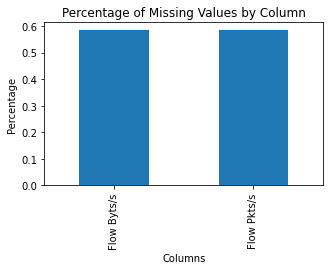

In [10]:
# 查看缺失值信息
df = data2.isnull().mean() * 100
# 只选择有缺失值的列
df =df[df > 0]
print('Null informations: \n')
print( df)
# 绘制柱状图
plt.figure(figsize=(5, 3))
df.sort_values().plot(kind='bar')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.show()

In [11]:
# 使用均值填充进行缺失值处理
data2['Flow Byts/s']=data2['Flow Byts/s'].fillna(data2['Flow Byts/s'].mean())
data2['Flow Pkts/s']=data2['Flow Pkts/s'].fillna(data2['Flow Pkts/s'].mean())

<AxesSubplot:xlabel='Label', ylabel='count'>

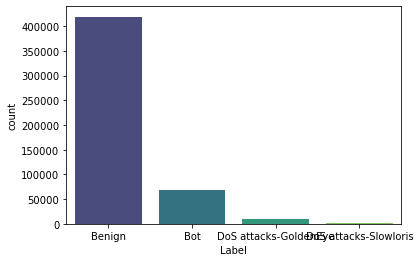

In [12]:
sns.countplot(data=data2, x='Label', palette='viridis') #查看原始标签分布

In [13]:
data3=data2.copy()

In [14]:
# 合并除了 'Benign' 之外的所有标签为 'Attack'
data3['Label'] = data3['Label'].apply(lambda x: 'Benign' if x == 'Benign' else 'DOS')
#转换Label
# 对目标值进行编码
label_encoder = LabelEncoder()
# 对单个列进行编码
data3['Label'] = label_encoder.fit_transform(data3['Label'])

<AxesSubplot:xlabel='Label', ylabel='count'>

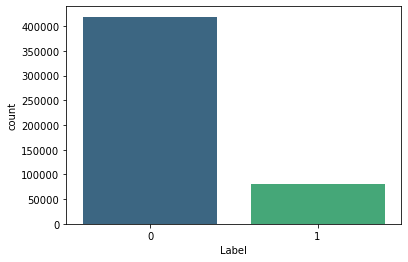

In [15]:
# 画图
sns.countplot(data=data3, x='Label', palette='viridis')

In [16]:
def split_data(x, y, test_size=0.2, shuffle=False):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=shuffle)
    return x_train, x_test, y_train, y_test

In [17]:
x = data3.drop(columns=['Label'])  # Features
y = data3['Label']  # Target
x_train, x_test, y_train, y_test = split_data(x, y, test_size=0.2, shuffle=True)

In [19]:
y_train.head()

76255      1
1008720    0
132486     1
758181     0
271885     1
Name: Label, dtype: int64

In [15]:
from scipy.stats import zscore
features_train = zscore(x_train, axis=0, ddof=1)
features_test = zscore(x_test, axis=0, ddof=1)

区分training 和 Testing

In [17]:
from sklearn.impute import SimpleImputer
# Normalize the datasets
features_train = zscore(features_train, axis=0, ddof=1)
features_test = zscore(features_test, axis=0, ddof=1)

# Convert to DataFrame to handle NaN values
features_train_df = pd.DataFrame(features_train)  # Ensure features_train is converted to DataFrame
features_test_df = pd.DataFrame(features_test)    # Ensure features_test is converted to DataFrame

# Remove columns that contain only NaN values
features_train_df = features_train_df.dropna(axis=1, how='all')
features_test_df = features_test_df.dropna(axis=1, how='all')

# Align the training and test sets to ensure they have the same columns
features_train_df, features_test_df = features_train_df.align(features_test_df, join='outer', axis=1, fill_value=0)
feature_names = features_train_df.columns.tolist()
# Convert back to numpy arrays
features_train = features_train_df.to_numpy()
features_test = features_test_df.to_numpy()

# Use SimpleImputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
features_train = imputer.fit_transform(features_train)
features_test = imputer.transform(features_test)

K-Mean Clustering

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Define the K-means model
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the model to the training data
kmeans.fit(features_train)

# Predict clusters on the training and test data
train_clusters = kmeans.predict(features_train)
test_clusters = kmeans.predict(features_test)

# Calculate accuracy, F1-score, and confusion matrix for the training data
accuracy_train = accuracy_score(y_train, train_clusters)
f1_train = f1_score(y_train, train_clusters, average='weighted')
conf_matrix_train = confusion_matrix(y_train, train_clusters)

# Calculate accuracy, F1-score, and confusion matrix for the test data
accuracy_test = accuracy_score(y_test, test_clusters)
f1_test = f1_score(y_test, test_clusters, average='weighted')
conf_matrix_test = confusion_matrix(y_test, test_clusters)

# Print results
print("Training Results:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"F1-Score: {f1_train:.4f}")
print("Confusion Matrix:")
print(conf_matrix_train)

print("\nTesting Results:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print("Confusion Matrix:")
print(conf_matrix_test)


Training Results:
Accuracy: 0.6333
F1-Score: 0.6597
Confusion Matrix:
[[246589  88716]
 [ 57957   6738]]

Testing Results:
Accuracy: 0.6344
F1-Score: 0.6619
Confusion Matrix:
[[61784 22267]
 [14293  1656]]


In [20]:
# Count the true label distribution in the test set
true_label_counts_test = pd.Series(y_test).value_counts()
num_true_0_test = true_label_counts_test.get(0, 0)  # Count of true label 0
num_true_1_test = true_label_counts_test.get(1, 0)  # Count of true label 1

# Count the predicted cluster distribution in the test set
predicted_cluster_counts_test = pd.Series(test_clusters).value_counts()
num_pred_0_test = predicted_cluster_counts_test.get(0, 0)  # Count of predicted cluster 0
num_pred_1_test = predicted_cluster_counts_test.get(1, 0)  # Count of predicted cluster 1

# Print the results
print("Test set (True Label counts):")
print("Label 0 count:", num_true_0_test)
print("Label 1 count:", num_true_1_test)

print("\nTest set (Predicted Cluster counts):")
print("Cluster 0 count:", num_pred_0_test)
print("Cluster 1 count:", num_pred_1_test)
# Count the true label distribution in the training set
true_label_counts_train = pd.Series(y_train).value_counts()
num_true_0_train = true_label_counts_train.get(0, 0)  # Count of true label 0
num_true_1_train = true_label_counts_train.get(1, 0)  # Count of true label 1

# Count the predicted cluster distribution in the training set
predicted_cluster_counts_train = pd.Series(train_clusters).value_counts()
num_pred_0_train = predicted_cluster_counts_train.get(0, 0)  # Count of predicted cluster 0
num_pred_1_train = predicted_cluster_counts_train.get(1, 0)  # Count of predicted cluster 1

# Print the results
print("\nTraining set (True Label counts):")
print("Label 0 count:", num_true_0_train)
print("Label 1 count:", num_true_1_train)

print("\nTraining set (Predicted Cluster counts):")
print("Cluster 0 count:", num_pred_0_train)
print("Cluster 1 count:", num_pred_1_train)

Test set (True Label counts):
Label 0 count: 83843
Label 1 count: 16157

Test set (Predicted Cluster counts):
Cluster 0 count: 76063
Cluster 1 count: 23937

Training set (True Label counts):
Label 0 count: 335513
Label 1 count: 64487

Training set (Predicted Cluster counts):
Cluster 0 count: 304619
Cluster 1 count: 95381


In [21]:
from sklearn.metrics import silhouette_score

# Take a random sample of 10,000 points for quicker calculation
sample_size = 10000
random_indices = np.random.choice(len(features_train), sample_size, replace=False)
features_sample = features_train[random_indices]
clusters_sample = train_clusters[random_indices]

silhouette_train = silhouette_score(features_sample, clusters_sample)
print("Silhouette Coefficient for Training set (sampled): {:.2f}%".format(silhouette_train * 100))

# Take a random sample of 10,000 points for quicker calculation

random_indices = np.random.choice(len(features_test), sample_size, replace=False)
features_sample = features_test[random_indices]
clusters_sample = test_clusters[random_indices]

silhouette_test = silhouette_score(features_sample, clusters_sample)
print("Silhouette Coefficient for Test set (sampled): {:.2f}%".format(silhouette_test * 100))

Silhouette Coefficient for Training set (sampled): 0.35582964071728007
Silhouette Coefficient for Test set (sampled): 0.3753101293382145


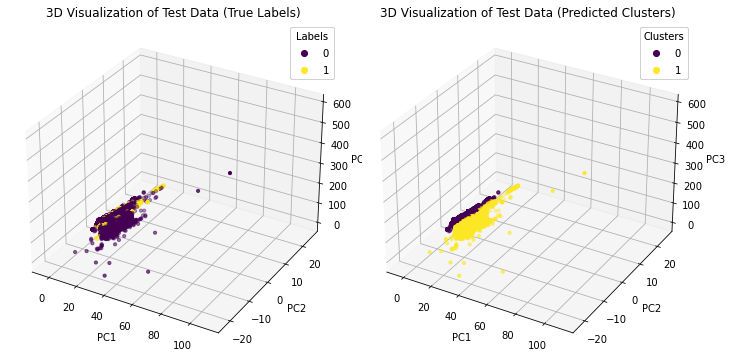

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce to 3 dimensions on test data
pca = PCA(n_components=3)
test_data_pca = pca.fit_transform(features_test)

# Plot for True Labels
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(test_data_pca[:, 0], test_data_pca[:, 1], test_data_pca[:, 2], 
                       c=y_test, cmap='viridis', s=10)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('3D Visualization of Test Data (True Labels)')
legend1 = ax1.legend(*scatter1.legend_elements(), title="Labels")
ax1.add_artist(legend1)

# Plot for Predicted Clusters
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(test_data_pca[:, 0], test_data_pca[:, 1], test_data_pca[:, 2], 
                       c=test_clusters, cmap='viridis', s=10)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('3D Visualization of Test Data (Predicted Clusters)')
legend2 = ax2.legend(*scatter2.legend_elements(), title="Clusters")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()

逻辑回归

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)  # Increase max_iter if needed
model.fit(features_train, y_train)

# Make predictions on the test data
y_pred = model.predict(features_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
conf_matrix = confusion_matrix(y_train, y_pred)
report = classification_report(y_train, y_pred)

# Print evaluation results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.9813325
Confusion Matrix:
 [[328892   6621]
 [   846  63641]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    335513
           1       0.91      0.99      0.94     64487

    accuracy                           0.98    400000
   macro avg       0.95      0.98      0.97    400000
weighted avg       0.98      0.98      0.98    400000



In [24]:
# Import the Python libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Testing, for sklearn libriary if applicable
predicted_labels = model.predict(features_test)

# Performance metrics
accuracy = accuracy_score(y_test, predicted_labels)
fscore = f1_score(y_test, predicted_labels)

# Show the results: accuracy and training time
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1-Score: {:.2f}%'.format(fscore * 100))

Accuracy: 0.89746
F1-Score: 0.7476124840011814


找前十个重要的参数

In [28]:
# Check the length of feature names and coefficients
coefficients = model.coef_.flatten()  # Flatten if 2D for binary classification

# Print lengths for debugging
print("Number of features:", len(feature_names))
print("Number of coefficients:", len(coefficients))

# If they match, proceed with creating the DataFrame
if len(feature_names) == len(coefficients):
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coefficients)
    })

    # Sort the DataFrame by importance in descending order and select the top 10 features
    top_features = coef_df.sort_values(by='importance', ascending=False).head(10)

    # Print the top 10 features
    print("Top 10 Most Important Features:")
    print(top_features)
else:
    print("Mismatch in lengths: Cannot create the DataFrame.")

Number of features: 68
Number of coefficients: 68
Top 10 Most Important Features:
              feature  importance
34         Fwd Pkts/s   21.786737
16        Flow Pkts/s   21.151839
40        Pkt Len Var   19.547521
15        Flow Byts/s   14.255463
49       Pkt Size Avg   13.431615
58  Fwd Act Data Pkts   13.214676
37        Pkt Len Max   13.204450
14    Bwd Pkt Len Std   13.189734
35         Bwd Pkts/s   12.865564
11    Bwd Pkt Len Max   10.864306


随机森林

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Indices of the top 10 features (replace these with the actual indices if different)
top_feature_indices = [34, 16, 40, 15, 49, 58, 37, 48, 35, 11]

# Select only the top 10 features from the training and test arrays
features_train_top10 = features_train[:, top_feature_indices]
features_test_top10 = features_test[:, top_feature_indices]

# Initialize and train the Random Forest model on the top 10 features
rf_model_top10 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_top10.fit(features_train_top10, y_train)

# Make predictions and evaluate the model
y_pred = rf_model_top10.predict(features_train_top10)
accuracy = accuracy_score(y_train, y_pred)
conf_matrix = confusion_matrix(y_train, y_pred)
report = classification_report(y_train, y_pred)

# Print evaluation results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 99.23%
Confusion Matrix:
 [[334585    928]
 [  2149  62338]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    335513
           1       0.99      0.97      0.98     64487

    accuracy                           0.99    400000
   macro avg       0.99      0.98      0.99    400000
weighted avg       0.99      0.99      0.99    400000



In [40]:
# Testing, for sklearn libriary if applicable
predicted_labels = rf_model_top10.predict(features_test_top10)

# Performance metrics
accuracy = accuracy_score(y_test, predicted_labels)
fscore = f1_score(y_test, predicted_labels)

# Show the results: accuracy and training time
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1-Score: {:.2f}%'.format(fscore * 100))

Accuracy: 97.11%
F1-Score: 90.30%


多分类

In [20]:
# Assuming `data2` is a DataFrame and the label column is named 'label'
unique_labels = data2['Label'].unique()
print("Unique labels in the 'label' column:", unique_labels)

Unique labels in the 'label' column: ['Benign' 'Bot' 'DoS attacks-GoldenEye' 'DoS attacks-Slowloris']


In [21]:
data5=data2.copy()

In [22]:
label_encoder = LabelEncoder()

# Fit and transform the 'Label' column in `data2`
data5['Label'] = label_encoder.fit_transform(data5['Label'])

# Display the numeric labels and their mappings
label_mappings = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mappings:", label_mappings)
print("Data with numeric labels:\n", data2.head())

Label mappings: {'Benign': 0, 'Bot': 1, 'DoS attacks-GoldenEye': 2, 'DoS attacks-Slowloris': 3}
Data with numeric labels:
         Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
76608        443         6         749769             9             7   
25825       8080         6            530             2             0   
792140         0         0      112638408             3             0   
905595       443         6         865910            11             8   
282235      8080         6          10312             3             4   

        TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  \
76608               512             4473              194                0   
25825                 0                0                0                0   
792140                0                0                0                0   
905595              541             5079              194                0   
282235              326              129        

<AxesSubplot:xlabel='Label', ylabel='count'>

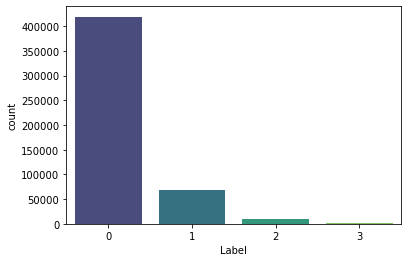

In [24]:
# 画图
sns.countplot(data=data5, x='Label', palette='viridis')

In [29]:
x_multi = data5.drop(columns=['Label'])  # Features
y_multi = data5['Label']  # Target
x_train_multi, x_test_multi, y_train_multi, y_test_multi = split_data(x_multi, y_multi, test_size=0.2, shuffle=True)

In [30]:
y_train_multi.head()

698369    0
951996    0
753846    0
666731    0
507945    0
Name: Label, dtype: int64

In [31]:
from scipy.stats import zscore
features_train_multi = zscore(x_train_multi, axis=0, ddof=1)
features_test_multi = zscore(x_test_multi, axis=0, ddof=1)

In [32]:
from sklearn.impute import SimpleImputer
# Normalize the datasets
features_train_multi = zscore(features_train_multi, axis=0, ddof=1)
features_test_multi = zscore(features_test_multi, axis=0, ddof=1)

# Convert to DataFrame to handle NaN values
features_train_df = pd.DataFrame(features_train_multi)  # Ensure features_train is converted to DataFrame
features_test_df = pd.DataFrame(features_test_multi)    # Ensure features_test is converted to DataFrame

# Remove columns that contain only NaN values
features_train_df = features_train_df.dropna(axis=1, how='all')
features_test_df = features_test_df.dropna(axis=1, how='all')

# Align the training and test sets to ensure they have the same columns
features_train_df, features_test_df = features_train_df.align(features_test_df, join='outer', axis=1, fill_value=0)
feature_names = features_train_df.columns.tolist()
# Convert back to numpy arrays
features_train_multi = features_train_df.to_numpy()
features_test_multi = features_test_df.to_numpy()

# Use SimpleImputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
features_train_multi = imputer.fit_transform(features_train_multi)
features_test_multi = imputer.transform(features_test_multi)

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Define the K-means model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the model to the training data
kmeans.fit(features_train_multi)

# Predict clusters on the training and test data
train_clusters = kmeans.predict(features_train_multi)
test_clusters = kmeans.predict(features_test_multi)

# Calculate accuracy, F1-score, and confusion matrix for the training data
accuracy_train = accuracy_score(y_train_multi, train_clusters)
f1_train = f1_score(y_train_multi, train_clusters, average='weighted')
conf_matrix_train = confusion_matrix(y_train_multi, train_clusters)

# Calculate accuracy, F1-score, and confusion matrix for the test data
accuracy_test = accuracy_score(y_test_multi, test_clusters)
f1_test = f1_score(y_test_multi, test_clusters, average='weighted')
conf_matrix_test = confusion_matrix(y_test_multi, test_clusters)

# Print results
print("Training Results:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"F1-Score: {f1_train:.4f}")
print("Confusion Matrix:")
print(conf_matrix_train)

print("\nTesting Results:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print("Confusion Matrix:")
print(conf_matrix_test)


Training Results:
Accuracy: 0.6315
F1-Score: 0.6822
Confusion Matrix:
[[223750  79947  18640  13156]
 [ 27686  26850      0      0]
 [  2171   5069    612     33]
 [   631     22     35   1398]]

Testing Results:
Accuracy: 0.6323
F1-Score: 0.6828
Confusion Matrix:
[[55978 19971  4530  3384]
 [ 6871  6749     0     0]
 [  543  1288   144     8]
 [  159     8    10   357]]


In [34]:
# Count the true label distribution in the test set
true_label_counts_test = pd.Series(y_test_multi).value_counts()
num_true_0_test = true_label_counts_test.get(0, 0)  # Count of true label 0
num_true_1_test = true_label_counts_test.get(1, 0)  # Count of true label 1

# Count the predicted cluster distribution in the test set
predicted_cluster_counts_test = pd.Series(test_clusters).value_counts()
num_pred_0_test = predicted_cluster_counts_test.get(0, 0)  # Count of predicted cluster 0
num_pred_1_test = predicted_cluster_counts_test.get(1, 0)  # Count of predicted cluster 1

# Print the results
print("Test set (True Label counts):")
print("Label 0 count:", num_true_0_test)
print("Label 1 count:", num_true_1_test)

print("\nTest set (Predicted Cluster counts):")
print("Cluster 0 count:", num_pred_0_test)
print("Cluster 1 count:", num_pred_1_test)
# Count the true label distribution in the training set
true_label_counts_train = pd.Series(y_train_multi).value_counts()
num_true_0_train = true_label_counts_train.get(0, 0)  # Count of true label 0
num_true_1_train = true_label_counts_train.get(1, 0)  # Count of true label 1

# Count the predicted cluster distribution in the training set
predicted_cluster_counts_train = pd.Series(train_clusters).value_counts()
num_pred_0_train = predicted_cluster_counts_train.get(0, 0)  # Count of predicted cluster 0
num_pred_1_train = predicted_cluster_counts_train.get(1, 0)  # Count of predicted cluster 1

# Print the results
print("\nTraining set (True Label counts):")
print("Label 0 count:", num_true_0_train)
print("Label 1 count:", num_true_1_train)

print("\nTraining set (Predicted Cluster counts):")
print("Cluster 0 count:", num_pred_0_train)
print("Cluster 1 count:", num_pred_1_train)

Test set (True Label counts):
Label 0 count: 83863
Label 1 count: 13620

Test set (Predicted Cluster counts):
Cluster 0 count: 63551
Cluster 1 count: 28016

Training set (True Label counts):
Label 0 count: 335493
Label 1 count: 54536

Training set (Predicted Cluster counts):
Cluster 0 count: 254238
Cluster 1 count: 111888


In [37]:
from sklearn.metrics import silhouette_score

# Take a random sample of 10,000 points for quicker calculation
sample_size = 10000
random_indices = np.random.choice(len(features_train_multi), sample_size, replace=False)
features_sample = features_train_multi[random_indices]
clusters_sample = train_clusters[random_indices]

silhouette_train = silhouette_score(features_sample, clusters_sample)
print("Silhouette Coefficient for Training set (sampled): {:.2f}%".format(silhouette_train * 100))

# Take a random sample of 10,000 points for quicker calculation

random_indices = np.random.choice(len(features_test_multi), sample_size, replace=False)
features_sample = features_test_multi[random_indices]
clusters_sample = test_clusters[random_indices]

silhouette_test = silhouette_score(features_sample, clusters_sample)
print("Silhouette Coefficient for Test set (sampled): {:.2f}%".format(silhouette_test * 100))

Silhouette Coefficient for Training set (sampled): 36.00%
Silhouette Coefficient for Test set (sampled): 35.88%


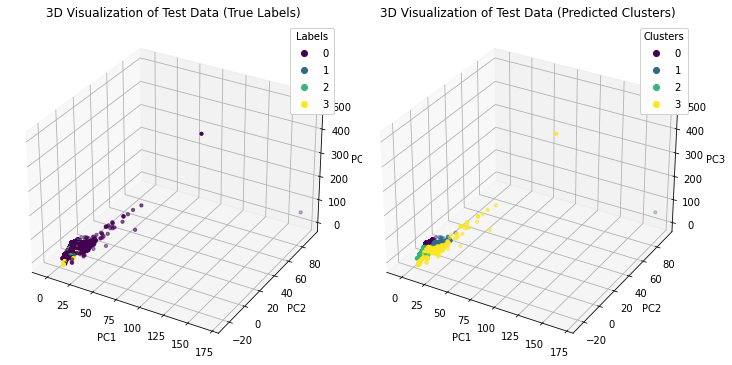

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce to 3 dimensions on test data
pca = PCA(n_components=3)
test_data_pca = pca.fit_transform(features_test_multi)

# Plot for True Labels
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(test_data_pca[:, 0], test_data_pca[:, 1], test_data_pca[:, 2], 
                       c=y_test_multi, cmap='viridis', s=10)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('3D Visualization of Test Data (True Labels)')
legend1 = ax1.legend(*scatter1.legend_elements(), title="Labels")
ax1.add_artist(legend1)

# Plot for Predicted Clusters
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(test_data_pca[:, 0], test_data_pca[:, 1], test_data_pca[:, 2], 
                       c=test_clusters, cmap='viridis', s=10)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('3D Visualization of Test Data (Predicted Clusters)')
legend2 = ax2.legend(*scatter2.legend_elements(), title="Clusters")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()

逻辑回归

In [45]:
# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)  # Increase max_iter if needed
model.fit(features_train_multi, y_train_multi)

# Make predictions on the test data
y_pred = model.predict(features_train_multi)

# Evaluate the model
accuracy = accuracy_score(y_train_multi, y_pred)
conf_matrix = confusion_matrix(y_train_multi, y_pred)
report = classification_report(y_train_multi, y_pred)

# Print evaluation results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.9869025
Confusion Matrix:
 [[330320   5051     18    104]
 [    34  54502      0      0]
 [     0      0   7878      7]
 [    24      0      1   2061]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    335493
           1       0.92      1.00      0.96     54536
           2       1.00      1.00      1.00      7885
           3       0.95      0.99      0.97      2086

    accuracy                           0.99    400000
   macro avg       0.97      0.99      0.98    400000
weighted avg       0.99      0.99      0.99    400000



In [49]:
# Import the Python libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Testing, for sklearn libriary if applicable
predicted_labels = model.predict(features_test_multi)

# Performance metrics
accuracy = accuracy_score(y_test_multi, predicted_labels)
fscore = f1_score(y_test_multi, predicted_labels, average='weighted')

# Show the results: accuracy and training time
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1-Score: {:.2f}%'.format(fscore * 100))

Accuracy: 96.92%
F1-Score: 97.04%


In [55]:
# 将 coefficients 数组重塑为 (number of features, number of classes)
coefficients_reshaped = coefficients.reshape(len(feature_names), -1)

# 计算每个特征系数的绝对值平均，以获得特征重要性
feature_importance = np.mean(np.abs(coefficients_reshaped), axis=1)

# 创建 DataFrame 以显示结果
coef_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# 按重要性排序并选择前10个特征
top_features = coef_df.sort_values(by='importance', ascending=False).head(10)
print("Top 10 Most Important Features:")
print(top_features)

Top 10 Most Important Features:
             feature  importance
21       Fwd IAT Tot   12.401827
22      Fwd IAT Mean    9.148729
25       Fwd IAT Min    8.366420
4       Tot Bwd Pkts    7.312624
31     Fwd PSH Flags    6.845913
23       Fwd IAT Std    6.642452
29       Bwd IAT Max    5.785469
8    Fwd Pkt Len Min    4.579943
5    TotLen Fwd Pkts    4.455883
55  Subflow Bwd Byts    4.120367


随机森林

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Indices of the top 10 features (replace these with the actual indices if different)
top_feature_indices = [21, 22, 25, 4, 31, 23, 29, 8, 5, 55]

# Select only the top 10 features from the training and test arrays
features_train_top10 = features_train_multi[:, top_feature_indices]
features_test_top10 = features_test_multi[:, top_feature_indices]

# Initialize and train the Random Forest model on the top 10 features
rf_model_top10 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_top10.fit(features_train_top10, y_train_multi)

# Make predictions and evaluate the model
y_pred = rf_model_top10.predict(features_train_top10)
accuracy = accuracy_score(y_train_multi, y_pred)
conf_matrix = confusion_matrix(y_train_multi, y_pred)
report = classification_report(y_train_multi, y_pred)

# Print evaluation results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 99.59%
Confusion Matrix:
 [[333904   1589      0      0]
 [     9  54527      0      0]
 [     0      0   7885      0]
 [    28      0      0   2058]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    335493
           1       0.97      1.00      0.99     54536
           2       1.00      1.00      1.00      7885
           3       1.00      0.99      0.99      2086

    accuracy                           1.00    400000
   macro avg       0.99      1.00      0.99    400000
weighted avg       1.00      1.00      1.00    400000



In [64]:
# Testing, for sklearn libriary if applicable
predicted_labels = rf_model_top10.predict(features_test_top10)

# Performance metrics
accuracy = accuracy_score(y_test_multi, predicted_labels)
fscore = f1_score(y_test_multi, predicted_labels, average='weighted')

# Show the results: accuracy and training time
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1-Score: {:.2f}%'.format(fscore * 100))

Accuracy: 84.25%
F1-Score: 77.16%


In [61]:
rf_model_full = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_full.fit(features_train_multi, y_train_multi)

# Make predictions and evaluate the model on the training set
y_pred_train = rf_model_full.predict(features_train_multi)
accuracy_train = accuracy_score(y_train_multi, y_pred_train)
conf_matrix_train = confusion_matrix(y_train_multi, y_pred_train)
report_train = classification_report(y_train_multi, y_pred_train)

# Print evaluation results for the training set
print("Training Set Accuracy: {:.2f}%".format(accuracy_train * 100))
print("Training Set Confusion Matrix:\n", conf_matrix_train)
print("Training Set Classification Report:\n", report_train)

# Testing on the test set if applicable
y_pred_test = rf_model_full.predict(features_test_multi)
accuracy_test = accuracy_score(y_test_multi, y_pred_test)
conf_matrix_test = confusion_matrix(y_test_multi, y_pred_test)
report_test = classification_report(y_test_multi, y_pred_test)

# Print evaluation results for the test set
print("Test Set Accuracy: {:.2f}%".format(accuracy_test * 100))
print("Test Set Confusion Matrix:\n", conf_matrix_test)
print("Test Set Classification Report:\n", report_test)

Training Set Accuracy: 100.00%
Training Set Confusion Matrix:
 [[335491      0      0      2]
 [     0  54536      0      0]
 [     0      0   7885      0]
 [     0      0      0   2086]]
Training Set Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    335493
           1       1.00      1.00      1.00     54536
           2       1.00      1.00      1.00      7885
           3       1.00      1.00      1.00      2086

    accuracy                           1.00    400000
   macro avg       1.00      1.00      1.00    400000
weighted avg       1.00      1.00      1.00    400000

Test Set Accuracy: 84.36%
Test Set Confusion Matrix:
 [[83863     0     0     0]
 [13428   192     0     0]
 [ 1927     0    56     0]
 [  283     0     0   251]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91     83863
           1       1.00      0.01  

In [62]:
# Testing, for sklearn libriary if applicable
predicted_labels = rf_model_full.predict(features_test_multi)

# Performance metrics
accuracy = accuracy_score(y_test_multi, predicted_labels)
fscore = f1_score(y_test_multi, predicted_labels, average='weighted')

# Show the results: accuracy and training time
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1-Score: {:.2f}%'.format(fscore * 100))

Accuracy: 84.36%
F1-Score: 77.54%


Regression Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     83863
           1       1.00      0.01      0.03     13620
           2       1.00      0.03      0.05      1983
           3       1.00      0.47      0.64       534

    accuracy                           0.84    100000
   macro avg       0.96      0.38      0.41    100000
weighted avg       0.87      0.84      0.78    100000

Confusion Matrix:
[[83863     0     0     0]
 [13428   192     0     0]
 [ 1927     0    56     0]
 [  283     0     0   251]]


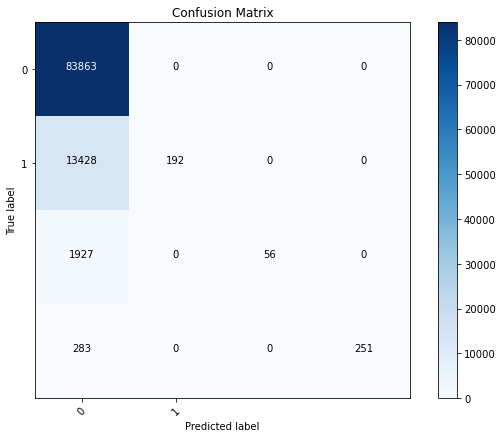

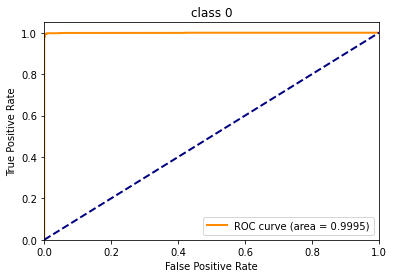

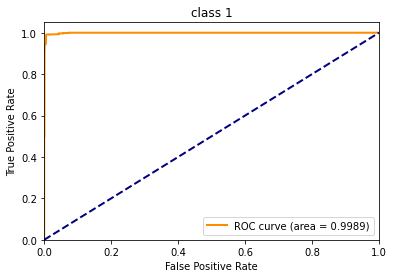

In [65]:
# 逻辑回归模型检验结果
y_pred = rf_model_full.predict(features_test_multi)
y_proba =rf_model_full.predict_proba(features_test_multi) 

# Print classification report
print("Regression Report:")
print(classification_report(y_test_multi, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_multi, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0, 1], rotation=45)
plt.yticks(tick_marks, [0, 1])
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


y_onehot=data_convert(np.array(y_test_multi ))
roc_auc_curve(y_onehot, y_proba)

随机森林多分类比二分类差很多